# Main code(used tensorflow)

# Import some libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import image_dataset_from_directory #Load data
from tensorflow.keras import layers #Data augmantation
from sklearn.model_selection import train_test_split #Split data

# Convert data to train and test

In [2]:
image_size = (500, 500)   #CHANGED
batch_size = 20           #CHANGED

train_ds = image_dataset_from_directory('/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset', validation_split=0.2, subset='training', seed=420, image_size=image_size, batch_size=batch_size)
# 20 batch of size 20
test_ds = image_dataset_from_directory('/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset', validation_split=0.2, subset='validation', seed=420, image_size=image_size, batch_size=batch_size)
# 5 batch of size 20



Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


# Check some data 

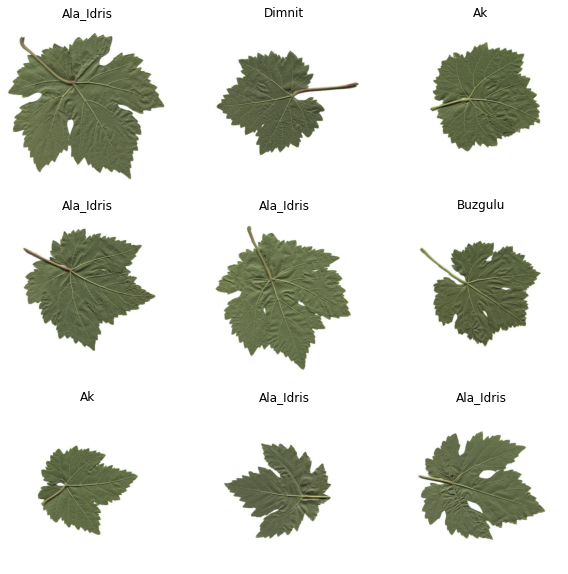

In [3]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data augmentation

In [3]:
#Create augm func
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomTranslation(0.06, 0.06),
  layers.RandomRotation(0.25),
  layers.RandomZoom(0.2, 0.2)
])

#Lists for train and label
Xs = []
Ys = []
for i in train_ds:
  for j in range(len(i[0])):
    Xs.append(i[0][j])
    Ys.append(i[1][j])
  
#Augment
for i in range(len(Xs)):
  augmented_image = data_augmentation(Xs[i])
  Xs.append(augmented_image)
  Ys.append(Ys[i])

  augmented_image1 = data_augmentation(Xs[i])
  Xs.append(augmented_image1)
  Ys.append(Ys[i])

  augmented_image2 = data_augmentation(Xs[i])
  Xs.append(augmented_image2)
  Ys.append(Ys[i])



# Split data to val and train

In [4]:
X_train, X_val, y_train, y_val = train_test_split(Xs, Ys, test_size=0.2, random_state=420)

#Back to dataSet
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.shuffle(buffer_size=1024).batch(20)         #CHANGED
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.shuffle(buffer_size=1024).batch(20)             #CHANGED

In [5]:
#resize data
train_data = train_ds.map(lambda image, label: (tf.image.resize(image, [256, 256])/255,label))  #ADDED
val_data = val_ds.map(lambda image, label: (tf.image.resize(image, [256, 256])/255, label))     #ADDED
test_data = test_ds.map(lambda image, label: (tf.image.resize(image, [256, 256])/255, label))   #ADDED

# First test with simple CNN

In [19]:
model = Sequential()

model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=5,activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)      

In [12]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)

In [14]:
m2tex(model)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 conv2d (Conv2D)               & (None, 254, 254, 16)        & 448        \\ \hline 
 max\_pooling2d (MaxPooling2D)  & (None, 127, 127, 16)        & 0          \\ \hline 
 conv2d\_1 (Conv2D)             & (None, 125, 125, 32)        & 4640       \\ \hline 
 max\_pooling2d\_1 (MaxPooling2D &  (None, 62, 62, 32)         & 0          \\ \hline 
                               &                             &            \\ \hline 
                               &                             &            \\ \hline 
 )                             &                             &            \\ \hline 
 flatten (Flatten)             & (None, 14400)               & 0          \\ \hline 
 dense (Dense)                 & (None, 256)                 & 3686656    \\ \hline 
 dense\_1 (Dense)               & (None, 5)                   & 1285       \

In [20]:
print("~~~~~~~~~~Fit_model:~~~~~~~~~~")
model.fit(train_data , epochs=10, validation_data=val_data)       #CHANGED
# Evaluate the model on the test data 
print("~~~~~~~~~~Evaluate_on_test_data~~~~~~~~~~~")
results = model.evaluate(test_data)                              #CHANGED
print("test loss, test acc:", results)
# Create confusion matrix
print("~~~~~~~~~~Confusion_Matrix~~~~~~~~~~")
real_label = []
pred_label = []
for i in test_data:                                              #CHANGED
  temp = model.predict(i[0])
  for j in temp:
    pred_label.append(max(range(len(j)), key=j.__getitem__))
  for j in i[1]:
    real_label.append(int(j))
confusion = tf.math.confusion_matrix(labels=real_label, predictions=pred_label, num_classes=5)
print(confusion)

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
64/64 [==============================] - 6s 78ms/step - loss: 1.6151 - accuracy: 0.2477 - val_loss: 1.5833 - val_accuracy: 0.2812
Epoch 2/10
64/64 [==============================] - 5s 75ms/step - loss: 1.5014 - accuracy: 0.3836 - val_loss: 1.5161 - val_accuracy: 0.3375
Epoch 3/10
64/64 [==============================] - 4s 69ms/step - loss: 1.2477 - accuracy: 0.4992 - val_loss: 1.5889 - val_accuracy: 0.3219
Epoch 4/10
64/64 [==============================] - 4s 69ms/step - loss: 0.9148 - accuracy: 0.6523 - val_loss: 2.0223 - val_accuracy: 0.3250
Epoch 5/10
64/64 [==============================] - 5s 76ms/step - loss: 0.5431 - accuracy: 0.8125 - val_loss: 2.2630 - val_accuracy: 0.3375
Epoch 6/10
64/64 [==============================] - 5s 77ms/step - loss: 0.2322 - accuracy: 0.9289 - val_loss: 3.4347 - val_accuracy: 0.3594
Epoch 7/10
64/64 [==============================] - 4s 69ms/step - loss: 0.0879 - accuracy: 0.9750 - val_loss: 4.2399 - val

# Ok, let's try some pre_trained models(in this case MobileNet V2)

In [21]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [22]:
#Create clasification layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
zero_layer = Dense(units=512,activation='relu')
first_layer = Dense(units=256,activation='relu')
second_layer = Dense(units=128,activation='relu')
third_layer = Dense(units=5,activation='softmax')

In [23]:
inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = zero_layer(x)
x = first_layer(x)
# x = second_layer(x)
outputs = third_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 512)               655872    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 5)                 1285  

In [26]:
m2tex(model)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 input\_2 (InputLayer)          & [(None, 256, 256, 3)]       & 0          \\ \hline 
 mobilenetv2\_1.00\_224 (Functio &  (None, 8, 8, 1280)         & 2257984    \\ \hline 
                               &                             &            \\ \hline 
 balAveragePooling2D)          &                             &            \\ \hline 
 dense\_6 (Dense)               & (None, 512)                 & 655872     \\ \hline 
 dense\_7 (Dense)               & (None, 256)                 & 131328     \\ \hline 
 dense\_9 (Dense)               & (None, 5)                   & 1285       \\ \hline 
===============================& ============================& ===========\\ \hline \hline 
Total params: 3,046,469 \\ 
Trainable params: 788,485 \\ 
Non-trainable params: 2,257,984 \\ \hline 
\end{tabular} 
\caption{Model summary for test.} 
\

In [27]:
print("~~~~~~~~~~Fit_model:~~~~~~~~~~")
model.fit(train_data, epochs=10, validation_data=val_data)            #CHANGED
# Evaluate the model on the test data 
print("~~~~~~~~~~Evaluate_on_test_data~~~~~~~~~~~")
results = model.evaluate(test_data)                                  #CHANGED
print("test loss, test acc:", results)
# Create confusion matrix
print("~~~~~~~~~~Confusion_Matrix~~~~~~~~~~")
real_label = []
pred_label = [] 
for i in test_data:                                                  #CHANGED
  temp = model.predict(i[0])
  for j in temp:
    pred_label.append(max(range(len(j)), key=j.__getitem__))
  for j in i[1]:
    real_label.append(int(j))
confusion = tf.math.confusion_matrix(labels=real_label, predictions=pred_label, num_classes=5)
print(confusion)

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
64/64 [==============================] - 10s 101ms/step - loss: 1.1887 - accuracy: 0.5602 - val_loss: 0.8111 - val_accuracy: 0.7875
Epoch 2/10
64/64 [==============================] - 6s 92ms/step - loss: 0.7330 - accuracy: 0.7508 - val_loss: 0.5733 - val_accuracy: 0.8500
Epoch 3/10
64/64 [==============================] - 6s 87ms/step - loss: 0.5528 - accuracy: 0.8328 - val_loss: 0.4523 - val_accuracy: 0.8625
Epoch 4/10
64/64 [==============================] - 6s 86ms/step - loss: 0.4500 - accuracy: 0.8641 - val_loss: 0.4093 - val_accuracy: 0.8594
Epoch 5/10
64/64 [==============================] - 6s 95ms/step - loss: 0.3825 - accuracy: 0.8781 - val_loss: 0.3858 - val_accuracy: 0.8625
Epoch 6/10
64/64 [==============================] - 6s 88ms/step - loss: 0.3301 - accuracy: 0.9031 - val_loss: 0.3764 - val_accuracy: 0.8562
Epoch 7/10
64/64 [==============================] - 6s 87ms/step - loss: 0.2882 - accuracy: 0.9180 - val_loss: 0.3874 - v

# Same model, different librarie

In [ ]:
#CODE IS IN ANOTHER FILE

# Use auto-encoder to see the result

In [2]:
import keras
from keras import layers

input_img = keras.Input(shape=(500, 500, 3))

x = layers.Conv2D(3, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
#middle of auto encoder
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [35]:
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 conv2d_22 (Conv2D)          (None, 500, 500, 3)       84        
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 250, 250, 3)      0         
 g2D)                                                            
                                                                 
 up_sampling2d_4 (UpSampling  (None, 500, 500, 3)      0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 500, 500, 3)       84        
                                                                 
Total params: 168
Trainable params: 168
Non-trainable param

In [36]:
m2tex(autoencoder)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 input\_6 (InputLayer)          & [(None, 500, 500, 3)]       & 0          \\ \hline 
 conv2d\_22 (Conv2D)            & (None, 500, 500, 3)         & 84         \\ \hline 
 max\_pooling2d\_13 (MaxPooling2 &  (None, 250, 250, 3)        & 0          \\ \hline 
                               &                             &            \\ \hline 
 )                             &                             &            \\ \hline 
 conv2d\_23 (Conv2D)            & (None, 500, 500, 3)         & 84         \\ \hline 
===============================& ============================& ===========\\ \hline \hline 
Total params: 168 \\ 
Trainable params: 168 \\ 
Non-trainable params: 0 \\ \hline 
\end{tabular} 
\caption{Model summary for test.} 
\label{tab:model-summary} 
\end{table}


In [3]:
image_size = (500, 500)
batch_size = 1
all_data = image_dataset_from_directory('/content/drive/MyDrive/Grapevine_Leaves_Image_Dataset', seed=420, image_size=image_size, batch_size=batch_size)

all_images = []
for i in all_data:
  image, label = i
  all_images.append(image/255)

  
dataset = tf.data.Dataset.from_tensor_slices((all_images, all_images))

Found 500 files belonging to 5 classes.
Using 250 files for validation.


In [4]:
autoencoder.fit(dataset, epochs=30)

Epoch 1/30
250/250 [==============================] - 16s 10ms/step - loss: 0.3734
Epoch 2/30
250/250 [==============================] - 3s 11ms/step - loss: 0.2404
Epoch 3/30
250/250 [==============================] - 3s 10ms/step - loss: 0.2242
Epoch 4/30
250/250 [==============================] - 2s 10ms/step - loss: 0.2231
Epoch 5/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2225
Epoch 6/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2216
Epoch 7/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2208
Epoch 8/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2200
Epoch 9/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2194
Epoch 10/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2189
Epoch 11/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2185
Epoch 12/30
250/250 [==============================] - 2s 8ms/step - loss: 0.2182
Epoch 13/30
250/250 

In [5]:
# check the encoder 
for i in dataset:
  first_batch = i[0]
  break

In [6]:
decoded_imgs = autoencoder.predict(first_batch)


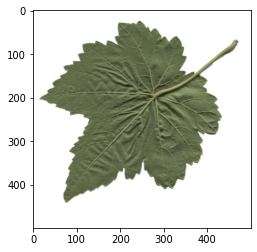

In [7]:
#real image
imgplot = plt.imshow(first_batch[0])

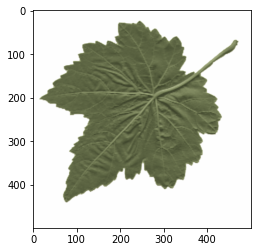

In [8]:
#image created
imgplot = plt.imshow(decoded_imgs[0])

In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
 up_sampling2d (UpSampling2D  (None, 500, 500, 3)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 500, 3)       84        
                                                                 
Total params: 168
Trainable params: 168
Non-trainable params:

In [10]:
#create new model
from tensorflow.keras.models import Model
model2 = Model(autoencoder.input, autoencoder.layers[-3].output)

In [9]:
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500, 500, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 500, 500, 3)       84        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 250, 250, 3)      0         
 )                                                               
                                                                 
Total params: 84
Trainable params: 84
Non-trainable params: 0
_________________________________________________________________


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


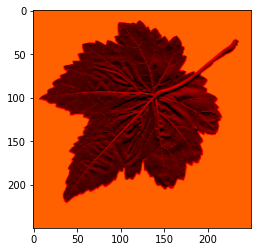

In [12]:
#check the model 2
decoded_imgss = model2.predict(first_batch)
imgplot = plt.imshow(decoded_imgss[0])

In [11]:
#dim-reduction 
#for train dataset
X_train = []
Y_train = []
for i in train_ds:
  result = model2.predict(i[0])
  X_train.append(result)
  Y_train.append(i[1])
train_ds_reduc = tf.data.Dataset.from_tensor_slices((X_train, Y_train))

#for val dataset
X_val = []
Y_val = []
for i in val_ds:
  result = model2.predict(i[0])
  X_val.append(result)
  Y_val.append(i[1])
val_ds_reduc = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

#for test dataset
X_test = []
Y_test = []
for i in test_ds:
  result = model2.predict(i[0])
  X_test.append(result)
  Y_test.append(i[1])
test_ds_reduc = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [13]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (250, 250)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
#Create clasification layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
zero_layer = Dense(units=512,activation='relu')
first_layer = Dense(units=256,activation='relu')
second_layer = Dense(units=128,activation='relu')
third_layer = Dense(units=5,activation='softmax')
#add clasification
inputs = tf.keras.Input(shape=(250, 250, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = zero_layer(x)
x = first_layer(x)
# x = second_layer(x)
outputs = third_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print("~~~~~~~~~~Fit_model:~~~~~~~~~~")
model.fit(train_ds_reduc, epochs=10, validation_data=val_ds_reduc)
# Evaluate the model on the test data 
print("~~~~~~~~~~Evaluate_on_test_data~~~~~~~~~~~")
results = model.evaluate(test_ds_reduc)
print("test loss, test acc:", results)
# Create confusion matrix
print("~~~~~~~~~~Confusion_Matrix~~~~~~~~~~")
real_label = []
pred_label = []
for i in test_ds_reduc:
  temp = model.predict(i[0])
  for j in temp:
    pred_label.append(max(range(len(j)), key=j.__getitem__))
  for j in i[1]:
    real_label.append(int(j))
confusion = tf.math.confusion_matrix(labels=real_label, predictions=pred_label, num_classes=5)
print(confusion)

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
48/48 [==============================] - 7s 64ms/step - loss: 1.5762 - accuracy: 0.2865 - val_loss: 1.4883 - val_accuracy: 0.3917
Epoch 2/10
48/48 [==============================] - 2s 46ms/step - loss: 1.4229 - accuracy: 0.4583 - val_loss: 1.4013 - val_accuracy: 0.4417
Epoch 3/10
48/48 [==============================] - 2s 46ms/step - loss: 1.3288 - accuracy: 0.5156 - val_loss: 1.3305 - val_accuracy: 0.4667
Epoch 4/10
48/48 [==============================] - 2s 46ms/step - loss: 1.2512 - accuracy: 0.5469 - val_loss: 1.2799 - val_accuracy: 0.4792
Epoch 5/10
48/48 [==============================] - 2s 46ms/step - loss: 1.1867 - accuracy: 0.5802 - val_loss: 1.2421 - val_accuracy: 0.5125
Epoch 6/10
48/48 [==============================] - 2s 46ms/step - loss: 1.1326 - accuracy: 0.6021 - val_loss: 1.2119 - val_accuracy: 0.5167
Epoch 7/10
48/48 [==============================] - 2s 46ms/step - loss: 1.0840 - accuracy: 0.6135 - val_loss: 1.1833 - val

#Use SVM for the part of clasification after the cnn

In [6]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SIZE = (256, 256)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
inputs = tf.keras.Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
outputs = global_average_layer(x)
model = tf.keras.Model(inputs, outputs)
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [7]:
#get the data ready for the svm

#train data
X_train = []
Y_train = []
for i in train_data:
  result = model.predict(i[0])
  for j in range(len(i[0])):
    X_train.append(result[j])
    Y_train.append(i[1][j])

#val data
X_val = []
Y_val = []
for i in val_data:
  result = model.predict(i[0])
  for j in range(len(i[0])):
    X_val.append(result[j])
    Y_val.append(i[1][j])

#test data
X_test = []
Y_test = []
for i in test_data:
  result = model.predict(i[0])
  for j in range(len(i[0])):
    X_test.append(result[j])
    Y_test.append(i[1][j])

In [8]:
from sklearn import svm

In [9]:
#add train and val to gether
X_train_new = X_train + X_val
Y_train_new = Y_train + Y_val

clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train_new, Y_train_new)



SVC(decision_function_shape='ovo')

In [10]:
#get the result of the test dataset
predicted_list = []
for i in range(len(X_test)):
  result = clf.predict([X_test[i]])
  predicted_list.append(result)

In [12]:
#calculate accuracy
right = 0
wrong = 0
for i in range(len(predicted_list)):
  if predicted_list[i] == Y_test[i]:
    right += 1
  else:
    wrong += 1

acc = right / (right+wrong)
print(f"accuracy for svm is: {acc}")
print("Confusion_Matrix is as below: ")
confusion = tf.math.confusion_matrix(labels=Y_test, predictions=predicted_list, num_classes=5)
print(confusion)

accuracy for svm is: 0.94
Confusion_Matrix is as below: 
tf.Tensor(
[[17  1  0  1  0]
 [ 1 19  2  0  0]
 [ 1  0 16  2  0]
 [ 3  0  0 23  0]
 [ 1  0  0  0 13]], shape=(5, 5), dtype=int32)


# 10 validation cross fold 

## split the train to ten parts and import mobile net

In [6]:
len(train_data) + len(val_data)

60

In [13]:
Xlist_data = []
Ylist_data = []

for i in train_data:
  Xlist_data.append(i[0])
  Ylist_data.append(i[1])

for i in val_data:
  Xlist_data.append(i[0])
  Ylist_data.append(i[1])

tempE = 0
for i in range(10):
  train_kfold = []
  val_kfold = []

  tempE += 6
  
  val_kfold = tf.data.Dataset.from_tensor_slices((Xlist_data[tempE - 6: tempE], Ylist_data[tempE - 6: tempE]))  
  train_kfold = tf.data.Dataset.from_tensor_slices((Xlist_data[:tempE - 6] + Xlist_data[tempE:], Ylist_data[:tempE - 6] + Ylist_data[tempE:]))  


  # Create the base model from the pre-trained model MobileNet V2
  print(f"--------------------------the bacth {i} is for validation-------------------------")
  IMG_SIZE = (256, 256)
  IMG_SHAPE = IMG_SIZE + (3,)
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')
  base_model.trainable = False
  #Create clasification layer
  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  zero_layer = Dense(units=512,activation='relu')
  first_layer = Dense(units=256,activation='relu')
  second_layer = Dense(units=128,activation='relu')
  third_layer = Dense(units=5,activation='softmax')
  inputs = tf.keras.Input(shape=(256, 256, 3))
  x = base_model(inputs, training=False)
  x = global_average_layer(x)
  x = zero_layer(x)
  x = first_layer(x)
  # x = second_layer(x)
  outputs = third_layer(x)
  model = tf.keras.Model(inputs, outputs)
  base_learning_rate = 0.0001
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  
  print("~~~~~~~~~~Fit_model:~~~~~~~~~~")
  model.fit(train_kfold, epochs=10, validation_data=val_kfold)            #CHANGED
  # Evaluate the model on the test data 
  print("~~~~~~~~~~Evaluate_on_test_data~~~~~~~~~~~")
  results = model.evaluate(test_data)                                  #CHANGED
  print("test loss, test acc:", results)
  # Create confusion matrix
  print("~~~~~~~~~~Confusion_Matrix~~~~~~~~~~")
  real_label = []
  pred_label = [] 
  for i in test_data:                                                  #CHANGED
    temp = model.predict(i[0])
    for j in temp:
      pred_label.append(max(range(len(j)), key=j.__getitem__))
    for j in i[1]:
      real_label.append(int(j))
  confusion = tf.math.confusion_matrix(labels=real_label, predictions=pred_label, num_classes=5)
  print(confusion)

--------------------------the bacth 0 is for validation-------------------------


~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 5s 57ms/step - loss: 1.2726 - accuracy: 0.5417 - val_loss: 0.9919 - val_accuracy: 0.6750
Epoch 2/10
54/54 [==============================] - 2s 39ms/step - loss: 0.7767 - accuracy: 0.7556 - val_loss: 0.7408 - val_accuracy: 0.7500
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5837 - accuracy: 0.8222 - val_loss: 0.5995 - val_accuracy: 0.7917
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4720 - accuracy: 0.8574 - val_loss: 0.5167 - val_accuracy: 0.8500
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3968 - accuracy: 0.8806 - val_loss: 0.4658 - val_accuracy: 0.8583
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3404 - accuracy: 0.9037 - val_loss: 0.4302 - val_accuracy: 0.8583
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2949 - accuracy: 0.9222 - val_loss: 0.4033 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 5s 55ms/step - loss: 1.2093 - accuracy: 0.5333 - val_loss: 1.0621 - val_accuracy: 0.5750
Epoch 2/10
54/54 [==============================] - 2s 41ms/step - loss: 0.7358 - accuracy: 0.7611 - val_loss: 0.8221 - val_accuracy: 0.6833
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5447 - accuracy: 0.8287 - val_loss: 0.7146 - val_accuracy: 0.7500
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4368 - accuracy: 0.8657 - val_loss: 0.6614 - val_accuracy: 0.7750
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3611 - accuracy: 0.8981 - val_loss: 0.6388 - val_accuracy: 0.7917
Epoch 6/10
54/54 [==============================] - 2s 41ms/step - loss: 0.3050 - accuracy: 0.9222 - val_loss: 0.6286 - val_accuracy: 0.8000
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2606 - accuracy: 0.9380 - val_loss: 0.6225 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 6s 55ms/step - loss: 1.2157 - accuracy: 0.5528 - val_loss: 0.8816 - val_accuracy: 0.6833
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.7510 - accuracy: 0.7528 - val_loss: 0.6457 - val_accuracy: 0.7750
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5677 - accuracy: 0.8176 - val_loss: 0.5228 - val_accuracy: 0.8083
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4606 - accuracy: 0.8546 - val_loss: 0.4527 - val_accuracy: 0.8417
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3868 - accuracy: 0.8870 - val_loss: 0.4048 - val_accuracy: 0.8750
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3323 - accuracy: 0.9028 - val_loss: 0.3741 - val_accuracy: 0.8750
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2881 - accuracy: 0.9259 - val_loss: 0.3511 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 5s 55ms/step - loss: 1.2346 - accuracy: 0.5463 - val_loss: 0.9097 - val_accuracy: 0.7083
Epoch 2/10
54/54 [==============================] - 2s 41ms/step - loss: 0.7464 - accuracy: 0.7537 - val_loss: 0.6745 - val_accuracy: 0.7667
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5599 - accuracy: 0.8157 - val_loss: 0.5673 - val_accuracy: 0.8250
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4559 - accuracy: 0.8602 - val_loss: 0.5004 - val_accuracy: 0.8417
Epoch 5/10
54/54 [==============================] - 2s 42ms/step - loss: 0.3841 - accuracy: 0.8824 - val_loss: 0.4557 - val_accuracy: 0.8667
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3304 - accuracy: 0.9019 - val_loss: 0.4250 - val_accuracy: 0.8833
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2877 - accuracy: 0.9213 - val_loss: 0.4021 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 6s 67ms/step - loss: 1.1774 - accuracy: 0.5759 - val_loss: 0.8412 - val_accuracy: 0.7333
Epoch 2/10
54/54 [==============================] - 2s 42ms/step - loss: 0.7382 - accuracy: 0.7556 - val_loss: 0.6222 - val_accuracy: 0.8000
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5625 - accuracy: 0.8130 - val_loss: 0.5118 - val_accuracy: 0.8583
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4596 - accuracy: 0.8565 - val_loss: 0.4468 - val_accuracy: 0.8750
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3879 - accuracy: 0.8824 - val_loss: 0.4051 - val_accuracy: 0.8833
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3334 - accuracy: 0.9056 - val_loss: 0.3753 - val_accuracy: 0.8917
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2894 - accuracy: 0.9204 - val_loss: 0.3498 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 6s 55ms/step - loss: 1.2918 - accuracy: 0.5009 - val_loss: 0.8955 - val_accuracy: 0.7583
Epoch 2/10
54/54 [==============================] - 2s 41ms/step - loss: 0.8033 - accuracy: 0.7370 - val_loss: 0.6524 - val_accuracy: 0.7833
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.6021 - accuracy: 0.8028 - val_loss: 0.5296 - val_accuracy: 0.8583
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4869 - accuracy: 0.8352 - val_loss: 0.4645 - val_accuracy: 0.8583
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4090 - accuracy: 0.8602 - val_loss: 0.4197 - val_accuracy: 0.8750
Epoch 6/10
54/54 [==============================] - 2s 41ms/step - loss: 0.3498 - accuracy: 0.8944 - val_loss: 0.3881 - val_accuracy: 0.9083
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3036 - accuracy: 0.9167 - val_loss: 0.3635 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 6s 55ms/step - loss: 1.2231 - accuracy: 0.5509 - val_loss: 0.9212 - val_accuracy: 0.7083
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.7497 - accuracy: 0.7769 - val_loss: 0.6738 - val_accuracy: 0.7500
Epoch 3/10
54/54 [==============================] - 2s 44ms/step - loss: 0.5604 - accuracy: 0.8296 - val_loss: 0.5520 - val_accuracy: 0.8000
Epoch 4/10
54/54 [==============================] - 2s 41ms/step - loss: 0.4556 - accuracy: 0.8639 - val_loss: 0.4859 - val_accuracy: 0.8250
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3828 - accuracy: 0.8796 - val_loss: 0.4447 - val_accuracy: 0.8583
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3267 - accuracy: 0.9000 - val_loss: 0.4154 - val_accuracy: 0.8583
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2819 - accuracy: 0.9139 - val_loss: 0.3934 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 5s 54ms/step - loss: 1.2215 - accuracy: 0.5509 - val_loss: 0.8267 - val_accuracy: 0.7833
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.7426 - accuracy: 0.7731 - val_loss: 0.5868 - val_accuracy: 0.8250
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5596 - accuracy: 0.8352 - val_loss: 0.4813 - val_accuracy: 0.8500
Epoch 4/10
54/54 [==============================] - 2s 41ms/step - loss: 0.4555 - accuracy: 0.8611 - val_loss: 0.4230 - val_accuracy: 0.8833
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3837 - accuracy: 0.8880 - val_loss: 0.3875 - val_accuracy: 0.8833
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3280 - accuracy: 0.9083 - val_loss: 0.3609 - val_accuracy: 0.8750
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2827 - accuracy: 0.9204 - val_loss: 0.3411 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 5s 56ms/step - loss: 1.1600 - accuracy: 0.5722 - val_loss: 0.8919 - val_accuracy: 0.7083
Epoch 2/10
54/54 [==============================] - 2s 41ms/step - loss: 0.7135 - accuracy: 0.7759 - val_loss: 0.7076 - val_accuracy: 0.7333
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5406 - accuracy: 0.8296 - val_loss: 0.6200 - val_accuracy: 0.7417
Epoch 4/10
54/54 [==============================] - 2s 41ms/step - loss: 0.4396 - accuracy: 0.8694 - val_loss: 0.5735 - val_accuracy: 0.7583
Epoch 5/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3702 - accuracy: 0.8917 - val_loss: 0.5407 - val_accuracy: 0.7833
Epoch 6/10
54/54 [==============================] - 2s 45ms/step - loss: 0.3180 - accuracy: 0.9111 - val_loss: 0.5212 - val_accuracy: 0.8083
Epoch 7/10
54/54 [==============================] - 2s 41ms/step - loss: 0.2756 - accuracy: 0.9231 - val_loss: 0.5042 - val

~~~~~~~~~~Fit_model:~~~~~~~~~~
Epoch 1/10
54/54 [==============================] - 5s 56ms/step - loss: 1.2468 - accuracy: 0.5426 - val_loss: 0.8848 - val_accuracy: 0.7417
Epoch 2/10
54/54 [==============================] - 2s 40ms/step - loss: 0.7536 - accuracy: 0.7556 - val_loss: 0.6621 - val_accuracy: 0.8083
Epoch 3/10
54/54 [==============================] - 2s 40ms/step - loss: 0.5623 - accuracy: 0.8278 - val_loss: 0.5779 - val_accuracy: 0.8083
Epoch 4/10
54/54 [==============================] - 2s 40ms/step - loss: 0.4552 - accuracy: 0.8648 - val_loss: 0.5288 - val_accuracy: 0.8000
Epoch 5/10
54/54 [==============================] - 2s 41ms/step - loss: 0.3814 - accuracy: 0.8907 - val_loss: 0.4928 - val_accuracy: 0.8000
Epoch 6/10
54/54 [==============================] - 2s 40ms/step - loss: 0.3254 - accuracy: 0.9037 - val_loss: 0.4701 - val_accuracy: 0.8000
Epoch 7/10
54/54 [==============================] - 2s 40ms/step - loss: 0.2802 - accuracy: 0.9176 - val_loss: 0.4492 - val